# Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install osmnet
!pip install cs-brix
!pip install matplotlib==3.1.3
!pip install pandana
!pip install folium

In [ ]:
!git clone https://github.com/CityScope/CSL_HCMC.git

Cloning into 'CSL_HCMC'...
remote: Enumerating objects: 1957, done.
remote: Counting objects: 100% (617/617), done.
remote: Compressing objects: 100% (335/335), done.
remote: Total 1957 (delta 324), reused 515 (delta 276), pack-reused 1340
Receiving objects: 100% (1957/1957), 178.67 MiB | 13.93 MiB/s, done.
Resolving deltas: 100% (1001/1001), done.
Checking out files: 100% (542/542), done.


In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
import math
from scipy.spatial import cKDTree
from geopandas.tools import sjoin
import random
import pandas as pd
import pandana as pdna
import matplotlib
import time

# CityScope Brix
import brix
# Visualisations
import folium
import osmnet

# Read wards, POIs and buildings and filter for district 7

- consider SGP-non_interact area belongs to District 7 and the present scenario is 0

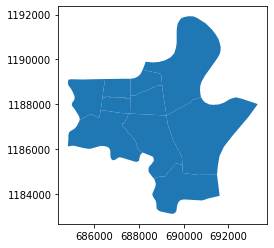

In [ ]:
administration_wards = gpd.read_file('/content/drive/MyDrive/Cityscope_L3_SGP/SDMC_L3_SGP/Data/2. GIS /District 7 _ boundary/Adminitration_Ward.shp')
# administration_wards[administration_wards['Commune_Na']=='Phu Thuan'].plot()
administration_wards.plot()

In [ ]:
administration_wards.head()

,OBJECTID,Commune_Na,District_N,Commune_ID,District_I,Level,Shape_Leng,Shape_Area,geometry
0,83,Tan Phong,District 7,27490,778,Ward,10313.616283,4.443845e+06,"POLYGON ((688157.068 1185832.387, 688069.048 1..."
1,186,Tan Hung,District 7,27475,778,Ward,6275.648279,2.194494e+06,"POLYGON ((686437.376 1189118.411, 686444.173 1..."
2,187,Tan Thuan Tay,District 7,27469,778,Ward,4328.127140,1.044603e+06,"POLYGON ((688165.082 1189540.830, 688220.310 1..."
3,188,Tan Thuan Dong,District 7,27466,778,Ward,12891.564155,7.481802e+06,"POLYGON ((688298.531 1189889.263, 688458.490 1..."
4,189,Binh Thuan,District 7,27478,778,Ward,5255.611015,1.626058e+06,"POLYGON ((689229.184 1187495.252, 689218.810 1..."


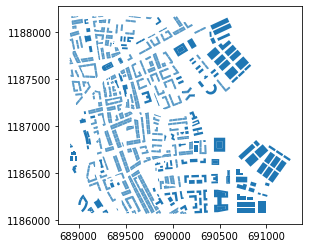

In [ ]:
building_non_interact = gpd.read_file('/content/drive/MyDrive/Cityscope_L3_SGP/SDMC_L3_SGP/Data/2. GIS /Building/non-interact/12 1 2022/Building.shp')
building_non_interact.plot()

In [ ]:
building_non_interact

,Storey,Height,B_Area,TypeCode,LandUseTyp,CSLLandTyp,BuildingTy,S_Roof,Note,Shape_Leng,Shape_Area,geometry
0,3.0,10.5,10000.0,CN,Industrial land,Industrial,NO,T,None,500.000000,10000.000000,"POLYGON Z ((690882.337 1186081.888 0.000, 6906..."
1,3.0,10.5,10000.0,CN,Industrial land,Industrial,NO,T,None,500.000000,10000.000000,"POLYGON Z ((690882.540 1186141.893 0.000, 6906..."
2,3.0,10.5,10800.0,CN,Industrial land,Industrial,NO,T,None,420.000000,10800.000000,"POLYGON Z ((690907.844 1186082.192 0.000, 6909..."
3,3.0,10.5,1500.0,CN,Industrial land,Industrial,NO,T,None,170.000000,1500.000000,"POLYGON Z ((690857.276 1186218.955 0.000, 6907..."
4,3.0,10.5,4800.0,CN,Industrial land,Industrial,NO,T,None,320.000000,4800.000000,"POLYGON Z ((690722.276 1186278.955 0.000, 6907..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5144,5.0,17.5,110.0,NNO,Existing and Renovated Residential,Residential - lowrise,NO,None,None,42.019825,110.068669,"POLYGON Z ((690018.030 1186073.436 0.000, 6900..."
5145,5.0,17.5,98.0,NNO,Existing and Renovated Residential,Residential - lowrise,NO,None,None,41.367971,97.861285,"POLYGON Z ((690111.215 1186068.415 0.000, 6901..."
5146,5.0,17.5,114.0,NNO,Existing and Renovated Residential,Residential - lowrise,NO,None,None,51.820141,113.713512,"POLYGON Z ((690138.445 1186068.415 0.000, 6901..."
5147,5.0,17.5,108.0,NNO,Existing and Renovated Residential,Residential - lowrise,NO,None,None,48.966728,108.293554,"POLYGON Z ((690094.749 1186068.415 0.000, 6900..."


In [ ]:
building_non_interact['CSLLandTyp'].unique()

array(['Industrial', 'Residential - highrise', 'Mixed use', 'Educational',
       'Administrative, Public facility', 'Religious', 'Healthcare',
       'Transportation, Infrastructure', 'Residential - lowrise'],
      dtype=object)

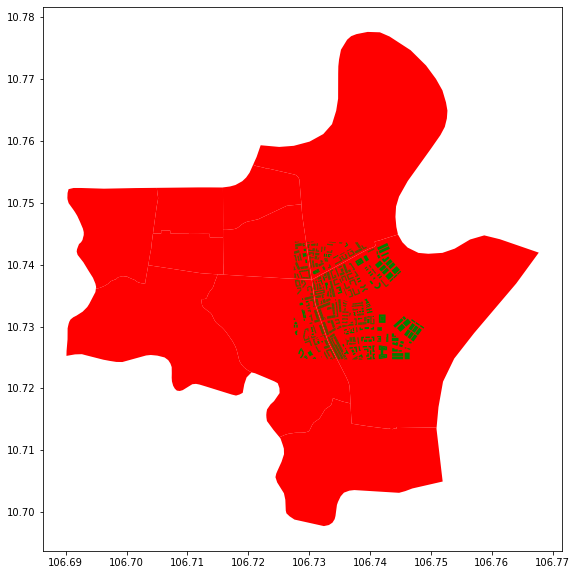

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(10,10))
administration_wards = administration_wards.to_crs('EPSG:4326')
administration_wards.plot(ax=ax, color='red')
building_non_interact.to_crs('EPSG:4326').plot(ax=ax, color='green')

In [ ]:
poi_path = '/content/drive/MyDrive/Cityscope_L3_SGP/SDMC_L3_SGP/Data/2. GIS /POIs/'
all_pois = {}
amenities = ['medical', 'park', 'education', 'commercial']

for i in [0]:
  all_pois[i] = {'medical' : gpd.read_file(poi_path+ 'Medical.shp'),
          'park' : gpd.read_file(poi_path + 'Greenery.shp'),
          'education' : gpd.read_file(poi_path + 'Education.shp'),
          'commercial' : gpd.read_file(poi_path+ 'Commercial_Services.shp')}

In [ ]:
data_path = "/content/drive/MyDrive/Cityscope_L3_SGP/SDMC_L3_SGP/Data/2. GIS "
dist7_wards = administration_wards[administration_wards['District_N'] == 'District 7']

In [ ]:
all_buildings={}
all_buildings[0] = building_non_interact

In [ ]:
dist_landuse = {}
dist_landuse[7] = {}
dist_landuse[7][0] = gpd.read_file('/content/drive/MyDrive/Cityscope_L3_SGP/SDMC_L3_SGP/Data/2. GIS /landuse/Shapfile/LandUse_Erase_In.shp')

#CityScope Spatial Urban Analysis

Filter district areas in simulation boundary

In [ ]:
#@title
# from shapely.geometry import Polygon
sim_bound = building_non_interact.to_crs('EPSG:32648').total_bounds
sim_bound = Polygon([[sim_bound[0], sim_bound[3]], [sim_bound[0], sim_bound[1]], [sim_bound[2], sim_bound[1]], [sim_bound[2], sim_bound[3]]])

sim_districts = {}
sim_districts[7] = administration_wards #wards in district 7
sim_district_areas = {}
sim_district_areas[7] = sim_districts[7].geometry.to_crs('EPSG:32648').intersection(sim_bound).area.sum()

In [ ]:
sim_district_areas[7].sum()

4900351.935033289

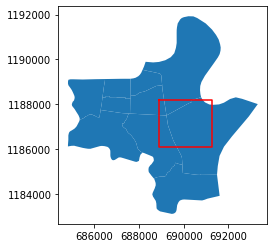

In [ ]:
# sim_districts[7].plot()
administration_wards.to_crs('EPSG:32648').plot()
plt.plot(*sim_bound.exterior.xy, color='red')


In [ ]:
print(administration_wards.to_crs('EPSG:4326').geometry.values[0])

POLYGON ((106.7205272736094 10.72259268223449, 106.7197180644904 10.72178375691358, 106.7193399837552 10.72068888493285, 106.719078361914 10.71928988795073, 106.7185621623859 10.7190253261355, 106.7179806371992 10.71885296927401, 106.7172961822276 10.71901447359363, 106.7147227971659 10.71980146372639, 106.7129172937539 10.72035360440996, 106.7119858346088 10.72062965409495, 106.7114005343994 10.72074307232404, 106.7107971760667 10.72068478060276, 106.709227760959 10.71973009752834, 106.7087404009421 10.7195929724576, 106.7082621227584 10.71965359173918, 106.7079291549628 10.7199602118781, 106.707652219321 10.72043309485462, 106.7074543776041 10.72113476076558, 106.7074113812574 10.72172636664734, 106.7074286571498 10.72246565420945, 106.7074118211981 10.72345149526341, 106.7071993249577 10.72403140589737, 106.7068471375 10.72456717343523, 106.7062517730314 10.72500618733535, 106.7050501676746 10.72530217597087, 106.7039788925587 10.72540404053088, 106.7032110930166 10.72532753040575, 

### Pre-computation

In [ ]:
#@title landtype.csv
landtypes = pd.read_csv('/content/drive/MyDrive/Cityscope_L3_SGP/SDMC_L3_SGP/Data/3. Table/Landtype.csv')
landtypes = landtypes.rename(columns={'NAICS_proportions':'NAICS_proportion'})
# landtypes

In [ ]:
landtypes.head()

,No.,CSLLandtype,LBCS,LBCS_proportion,NAICS,NAICS_proportion,Area per person (employee) (sqm/person),Area per person (resident) (sqm/person),Color
0,1,Residential - lowrise,"1100, 1110, 1210, 1220","0.5, 0.1, 0.2, 0.2",Null,Null,"0, 60, 60, 60","20, 20, 20, 20",#d2c700
1,2,Residential - highrise,1120,1,Null,Null,1200,25,#f5e200
2,3,"Commercial, Service","2100, 2200, 2300, 6500","0.1, 0.2, 0.5, 0.2","445110, 722110, 661114, 721110","0.1, 0.2, 0.5, 0.2","90, 13, 10, 100",0,#f28125
3,4,"Administrative, Public facility",2300,1,920000,1,10,0,#e30102
4,5,Industrial,3000,1,480000,1,30,0,#8900fe


In [ ]:
import random
import numpy as np
from PIL import ImageColor
#@title csv2json
def csv2json(typetable):
  types = {}
  typetable.insert(2, 'color', [[] for i in range(16)], True)
  # print(typetable.columns)
  for index in range(len(typetable)):
      #print(types[index])
      row = typetable[index:index+1]
      # print(row)
      row['CSLLandtype'] = row['CSLLandtype'].values[0].split(',')[0] #
      # if row['CSLLandtype'].values[0] == 'Residential - lowrise' or row['CSLLandtype'].values[0] == 'Residential - highrise':
      #   row['color'].values[0] = [255, 255, 0, 180]
      # else:
      #   row['color'].values[0] = types_old[row['CSLLandtype'].values[0]]['color'] #
      c = list(ImageColor.getcolor(row['Color'].values[0], 'RGB'))
      c.insert(3, 180)
      row['color'].values[0] = c
      land_type = row['CSLLandtype'].values[0]
      types[land_type] = {}
      types[land_type]['color'] = row['color'].values[0] #

      for attr in ['LBCS', 'NAICS']:
        types[land_type][attr] = {}
        codes = row[attr].values[0].split(', ')
        props = row[attr+'_proportion'].values[0].split(', ')
        sqm_pemp = row['Area per person (employee) (sqm/person)'].values[0].split(', ')
        sqm_pres = row['Area per person (resident) (sqm/person)'].values[0].split(', ')
        for idx, code in enumerate(codes):
          if code == 'Null':
            continue
          types[land_type][attr][code] = {}
          types[land_type][attr][code]['props'] = props[idx]
          if idx >= len(sqm_pemp):
            types[land_type][attr][code]['sqm_pemp'] = '0'
          else:
            types[land_type][attr][code]['sqm_pemp'] = sqm_pemp[idx]
          if idx >= len(sqm_pres):
            types[land_type][attr][code]['sqm_pres'] = '0'
          else:
            types[land_type][attr][code]['sqm_pres'] = sqm_pres[idx]
      
  return types

types = csv2json(landtypes)
# types

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
#@title def aggregate_area_attributes
def aggregate_area_attributes(attribute, total_area, type_info, digits=None): #compute capacity per each considered attribute
    """
    Takes as input the total capacity of a parcel/cell, the type description
    and an attributes of interest (eg. NAICS)
    Returns the total capacities associated with that attribute
    optionally reduce the precision of an attribute such as NAICS by supplying digits=n
    """
    aggregated={}
    # print("type info ", type_info)
    if attribute not in type_info:
        #print('attribute1', attribute)
        return aggregated
    if type_info[attribute] is not 'Null':
        for code in type_info[attribute]:
            if digits==None:
                code_digits=code
            else:
                code_digits=code[0:digits]
            # print(type_info[attribute][code]['sqm_pres'])
            sqm_pres = float(type_info[attribute][code]['sqm_pres'])
            if sqm_pres == 0:
              sqm_pres = np.inf
            # print(type_info[attribute][code]['sqm_pemp'])
            if (type_info[attribute][code]['sqm_pemp'] == 'Null'):
                type_info[attribute][code]['sqm_pemp'] = 0
            sqm_pemp = float(type_info[attribute][code]['sqm_pemp'])
            if sqm_pemp == 0:
              sqm_pemp = np.inf

            attr_capacity = total_area*float(type_info[attribute][code]['props'])*(1/sqm_pres+1/sqm_pemp)
            #print('cap', attr_capacity)
            if code_digits in aggregated:
                aggregated[code_digits]+= attr_capacity
            else:
                aggregated[code_digits]= attr_capacity
    return aggregated

In [ ]:
#@title def building_to_attributes
def building_to_attributes(row, types):
    name=row['CSLLandTyp']
    storeys=row['Storey']
    # print("storeys ", storeys)
    # print(name)
    type_info = types[name]
    
    total_area=storeys*row['Shape_Area'] #estimate total construction area of a building
    # print("row['ShapeArea']: ", row['ShapeArea'])
    # print("total_area: ", total_area)
    
    agg_naics=aggregate_area_attributes('NAICS', total_area, type_info, digits=2)
    # print('agg_naics', agg_naics)
    agg_lbcs=aggregate_area_attributes('LBCS', total_area, type_info, digits=1)
    # print('agg_lbcs', agg_lbcs)
    agg_res=aggregate_area_attributes('res_income', total_area, type_info, digits=None)
    # print('agg_res', agg_res)

    for naics in agg_naics:
        row['emp_naics_{}'.format(naics)]=agg_naics[naics]   
    for res in agg_res:
        row['res_income{}'.format(res)]=agg_res[res]
    row['emp_total']=sum(agg_naics.values())
    
    if '1' in agg_lbcs:
        cell_population=agg_lbcs['1']
        # print('agg_lbcs[1]', agg_lbcs['1'])
        # print('agg_lbcs', agg_lbcs)
    else:
        cell_population=0
    row['res_total']=cell_population

    return row

In [ ]:
#@title split name 'CSLLandTyp' in building & landuse
for index in range(len(building_non_interact)):
      row = building_non_interact[index:index+1]
      # print(row)
      row['CSLLandTyp'] = row['CSLLandTyp'].values[0].split(',')[0] #
# building_non_interact

#@title split name 'CSLLandTyp' in landuse
for index in range(len(dist_landuse[7][0])):
      row = dist_landuse[7][0][index:index+1]
      # print(row)
      row['CSLLandTyp'] = row['CSLLandTyp'].values[0].split(',')[0] #
# dist_landuse[7][0]

In [ ]:
#@title compute buildings in each district for housing density, emp density
dist_buildings = {}
dist_full_attr_buildings = {}

for dist_idx in [7]:
  dist_buildings[dist_idx] = {}
  dist_full_attr_buildings[dist_idx] = {}
  for sim_idx in [0]:
    # compute buildings in the simulation model
    dist_buildings[dist_idx][sim_idx] = all_buildings[sim_idx]
    print("Done computing district building in Scenario {} of District {}".format(sim_idx, dist_idx))
    # compute full attribute for emp/res 
    dist_full_attr_buildings[dist_idx][sim_idx] = dist_buildings[dist_idx][sim_idx].apply(lambda row: building_to_attributes(row, types), axis=1).fillna(0)
    print("Done computing district building with full attributes in Scenario {} of District {}".format(sim_idx, dist_idx))

full_attr_buildings = {}
for sim_idx in [0]:
  #compute for emp/res heatmap
  full_attr_buildings[sim_idx] = all_buildings[sim_idx].apply(lambda row: building_to_attributes(row, types), axis=1).fillna(0)
  print("Done computing scenario building with full attributes in Scenario {} ".format(sim_idx))

Done computing district building in Scenario 0 of District 7
Done computing district building with full attributes in Scenario 0 of District 7
Done computing scenario building with full attributes in Scenario 0 


In [ ]:
def normalise_indicator(raw_value, min_value, max_value):
    return (raw_value-min_value)/(max_value-min_value)

def normalise_indicator_max(raw_value, max_value):
    return raw_value/max_value

# Density

##Housing Density

In [ ]:
#@title Housing Density
high_building_ratio = 0.7 #@param {type:"number"}
base_area = 80.0 #@param {type:"number"}

sim_low_buildings = {}
sim_high_buildings = {}
sim_mix_buildings = {}
housing_density = {}
all_housing_densities = []

for dist_idx in [7]:
  sim_low_buildings[dist_idx] = {}
  sim_high_buildings[dist_idx] = {}
  sim_mix_buildings[dist_idx] = {}
  housing_density[dist_idx] = {}
  for sim_idx in [0]:
    sim_low_buildings[dist_idx][sim_idx] = dist_buildings[dist_idx][sim_idx][dist_buildings[dist_idx][sim_idx]['CSLLandTyp'] =='Residential - lowrise']
    sim_high_buildings[dist_idx][sim_idx] = dist_buildings[dist_idx][sim_idx][dist_buildings[dist_idx][sim_idx]['CSLLandTyp'] =='Residential - highrise']
    sim_mix_buildings[dist_idx][sim_idx] = dist_buildings[dist_idx][sim_idx][dist_buildings[dist_idx][sim_idx]['CSLLandTyp'] =='Mixed use']
    # print("no. sim low buildings: ", sim_low_buildings[dist_idx][sim_idx])
    # print("no. sim high buildings: ", sim_high_buildings[dist_idx][sim_idx][:1]['ShapeArea'])
    # print("no. sim mix buildings: ", sim_mix_buildings[dist_idx][sim_idx])

    # So don vi o nha thap tang
    num_low = len(sim_low_buildings[dist_idx][sim_idx])
    # print("num low: ", num_low)
    # So don vi o nha cao tang 
    # print(sim_high_buildings[dist_idx][sim_idx]['ShapeArea'])
    num_high = sum(sim_high_buildings[dist_idx][sim_idx]['Shape_Area']*sim_high_buildings[dist_idx][sim_idx]['Storey'])/ base_area
    # print("num high: ", num_high)

    # So don vi o cua khu Mixed-use
    # TODO: Thay vi hard code thi nen link voi landtype-v4.csv
    num_mix_high = sum(sim_mix_buildings[dist_idx][sim_idx]['Shape_Area']*high_building_ratio*sim_mix_buildings[dist_idx][sim_idx]['Storey'])/ base_area  #Dien tich de xay chung cu
    # print("num mix high: ", num_mix_high)
    #num_mix_low = sum(sim_mix_buildings[dist_idx][sim_idx]['ShapeArea']*0.3)/ 80  #Dien tich de xay nha pho
    housing_density[dist_idx][sim_idx] = (num_low + num_high + num_mix_high)/ sim_districts[dist_idx]['Shape_Area'].sum()
    all_housing_densities.append(housing_density[dist_idx][sim_idx])

print("housing_density", housing_density)


housing_density {7: {0: 0.0010823741447044107}}


In [ ]:
#@title min-max norm with other district values District 1, 2, 4, 7
housing_density_ref = {1: {0: 0.015407921123949486, 2: 0.015407921123949486, 3: 0.015407921123949486}, 2: {0: 0.0034935334844812095, 2: 0.0034935334844812095, 3: 0.0034935334844812095}, 4: {0: 0.011216879580099861, 2: 0.012416396956487979, 3: 0.011798563874942956}, 7: {0: 0.005422243439097122, 2: 0.005422243439097122, 3: 0.005422243439097122}}
print("housing_density_ref ", housing_density_ref)
all_housing_densities = []
for dist_idx in [1, 2, 4, 7]:
  for sim_idx in [0, 2, 3]:
    all_housing_densities.append(housing_density_ref[dist_idx][sim_idx])
all_housing_densities.append(housing_density[7][0])
min_housing_dens = min(all_housing_densities)
print('Min housing density: ', min_housing_dens)
max_housing_dens = max(all_housing_densities)
print('Max housing density: ', max_housing_dens)

norm_housing_density = {}
for dist_idx in [1, 2, 4, 7]:
  norm_housing_density[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    norm_housing_density[dist_idx][sim_idx] = normalise_indicator(housing_density_ref[dist_idx][sim_idx], min_housing_dens, max_housing_dens)
norm_housing_density['sgp_non_interact'] = {}
norm_housing_density['sgp_non_interact'][0] = normalise_indicator(housing_density[7][0], min_housing_dens, max_housing_dens)

print('norm housing density: ', norm_housing_density)

housing_density_ref  {1: {0: 0.015407921123949486, 2: 0.015407921123949486, 3: 0.015407921123949486}, 2: {0: 0.0034935334844812095, 2: 0.0034935334844812095, 3: 0.0034935334844812095}, 4: {0: 0.011216879580099861, 2: 0.012416396956487979, 3: 0.011798563874942956}, 7: {0: 0.005422243439097122, 2: 0.005422243439097122, 3: 0.005422243439097122}}
Min housing density:  0.0010823741447044107
Max housing density:  0.015407921123949486
norm housing density:  {1: {0: 1.0, 2: 1.0, 3: 1.0}, 2: {0: 0.1683118517757192, 2: 0.1683118517757192, 3: 0.1683118517757192}, 4: {0: 0.7074428257488788, 2: 0.7911755710413262, 3: 0.7480475088151409}, 7: {0: 0.3029461493289112, 2: 0.3029461493289112, 3: 0.3029461493289112}, 'sgp_non_interact': {0: 0.0}}


In [ ]:
#@title max norm with other district values District 1, 2, 4, 7
housing_density_ref = {1: {0: 0.015407921123949486, 2: 0.015407921123949486, 3: 0.015407921123949486}, 2: {0: 0.0034935334844812095, 2: 0.0034935334844812095, 3: 0.0034935334844812095}, 4: {0: 0.011216879580099861, 2: 0.012416396956487979, 3: 0.011798563874942956}, 7: {0: 0.005422243439097122, 2: 0.005422243439097122, 3: 0.005422243439097122}}
print("housing_density_ref ", housing_density_ref)
all_housing_densities = []
for dist_idx in [1, 2, 4, 7]:
  for sim_idx in [0, 2, 3]:
    all_housing_densities.append(housing_density_ref[dist_idx][sim_idx])
all_housing_densities.append(housing_density[7][0])

max_housing_dens = max(all_housing_densities)
print('Max housing density: ', max_housing_dens)

norm_housing_density = {}
for dist_idx in [1, 2, 4, 7]:
  norm_housing_density[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    norm_housing_density[dist_idx][sim_idx] = normalise_indicator_max(housing_density_ref[dist_idx][sim_idx], max_housing_dens)
norm_housing_density['sgp_non_interact'] = {}
norm_housing_density['sgp_non_interact'][0] = normalise_indicator_max(housing_density[7][0], max_housing_dens)

print('norm housing density: ', norm_housing_density)

housing_density_ref  {1: {0: 0.015407921123949486, 2: 0.015407921123949486, 3: 0.015407921123949486}, 2: {0: 0.0034935334844812095, 2: 0.0034935334844812095, 3: 0.0034935334844812095}, 4: {0: 0.011216879580099861, 2: 0.012416396956487979, 3: 0.011798563874942956}, 7: {0: 0.005422243439097122, 2: 0.005422243439097122, 3: 0.005422243439097122}}
Min housing density:  0.0010823741447044107
Max housing density:  0.015407921123949486
norm housing density:  {1: {0: 1.0, 2: 1.0, 3: 1.0}, 2: {0: 0.22673619993102082, 2: 0.22673619993102082, 3: 0.22673619993102082}, 4: {0: 0.7279943536746675, 2: 0.8058450492187686, 3: 0.7657466429136711}, 7: {0: 0.35191272044279825, 2: 0.35191272044279825, 3: 0.35191272044279825}, 'sgp_non_interact': {0: 0.07024790275061893}}


## Amenity Density

In [ ]:
#@title Amenity Density
amenity_density = {}
all_amenity_densities = []

for dist_idx in [7]:
  amenity_density[dist_idx] = {}
  for sim_idx in [0]:

    commercial_pois = all_pois[sim_idx]['commercial'][all_pois[sim_idx]['commercial']['District'] == 'District {}'.format(dist_idx)]
    education_pois = all_pois[sim_idx]['education'][all_pois[sim_idx]['education']['District'] == 'District {}'.format(dist_idx)]
    park_pois = all_pois[sim_idx]['park'][all_pois[sim_idx]['park']['District'] == 'District {}'.format(dist_idx)]
    medical_pois = all_pois[sim_idx]['medical'][all_pois[sim_idx]['medical']['District'] == 'District {}'.format(dist_idx)]

    amenity_density[dist_idx][sim_idx] = (len(commercial_pois) + len(education_pois) + len(park_pois) + len(medical_pois)) / sim_district_areas[dist_idx]
    all_amenity_densities.append(amenity_density[dist_idx][sim_idx])
print("amenity_density ", amenity_density)



amenity_density  {7: {0: 0.0003081411335387572}}


In [ ]:
#@title min-max norm with other district values District 1, 2, 4, 7
amenity_density_ref = {1: {0: 0.0007342429169259944, 2: 0.000737769847967997, 3: 0.000737769847967997}, 2: {0: 0.000420007847974523, 2: 0.00041045234367727425, 3: 0.00041045234367727425}, 4: {0: 0.00048819378878526084, 2: 0.0004960910412509048, 3: 0.0005781746047574461}, 7: {0: 0.00035108072929608645, 2: 0.00035108072929608645, 3: 0.00035108072929608645}}
print("amenity_density_ref ", amenity_density_ref)
all_amenity_densities = []
for dist_idx in [1, 2, 4, 7]:
  for sim_idx in [0, 2, 3]:
    all_amenity_densities.append(amenity_density_ref[dist_idx][sim_idx])
all_amenity_densities.append(amenity_density[7][0])
min_amenity_dens = min(all_amenity_densities)
print('Min amenity density: ', min_amenity_dens)
max_amenity_dens = max(all_amenity_densities)
print('Max amenity density: ', max_amenity_dens)

norm_amenity_density = {}
for dist_idx in [1, 2, 4, 7]:
  norm_amenity_density[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    norm_amenity_density[dist_idx][sim_idx] = normalise_indicator(amenity_density_ref[dist_idx][sim_idx], min_amenity_dens, max_amenity_dens)
norm_amenity_density['sgp_non_interact'] = {}
norm_amenity_density['sgp_non_interact'][0] = normalise_indicator(amenity_density[7][0], min_amenity_dens, max_amenity_dens)

print('norm amenity density: ', norm_amenity_density)

amenity_density_ref  {1: {0: 0.0007342429169259944, 2: 0.000737769847967997, 3: 0.000737769847967997}, 2: {0: 0.000420007847974523, 2: 0.00041045234367727425, 3: 0.00041045234367727425}, 4: {0: 0.00048819378878526084, 2: 0.0004960910412509048, 3: 0.0005781746047574461}, 7: {0: 0.00035108072929608645, 2: 0.00035108072929608645, 3: 0.00035108072929608645}}
Min amenity density:  0.0003081411335387572
Max amenity density:  0.000737769847967997
norm amenity density:  {1: {0: 0.9917907464665435, 2: 1.0, 3: 1.0}, 2: {0: 0.26037997619498104, 2: 0.23813866881415763, 3: 0.23813866881415763}, 4: {0: 0.4190889696134555, 2: 0.4374705446814427, 3: 0.6285275219032495}, 7: {0: 0.0999458237198469, 2: 0.0999458237198469, 3: 0.0999458237198469}, 'sgp_non_interact': {0: 0.0}}


In [ ]:
#@title max norm with other district values District 1, 2, 4, 7
amenity_density_ref = {1: {0: 0.0007342429169259944, 2: 0.000737769847967997, 3: 0.000737769847967997}, 2: {0: 0.000420007847974523, 2: 0.00041045234367727425, 3: 0.00041045234367727425}, 4: {0: 0.00048819378878526084, 2: 0.0004960910412509048, 3: 0.0005781746047574461}, 7: {0: 0.00035108072929608645, 2: 0.00035108072929608645, 3: 0.00035108072929608645}}
print("amenity_density_ref ", amenity_density_ref)
all_amenity_densities = []
for dist_idx in [1, 2, 4, 7]:
  for sim_idx in [0, 2, 3]:
    all_amenity_densities.append(amenity_density_ref[dist_idx][sim_idx])
all_amenity_densities.append(amenity_density[7][0])

max_amenity_dens = max(all_amenity_densities)
print('Max amenity density: ', max_amenity_dens)

norm_amenity_density = {}
for dist_idx in [1, 2, 4, 7]:
  norm_amenity_density[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    norm_amenity_density[dist_idx][sim_idx] = normalise_indicator_max(amenity_density_ref[dist_idx][sim_idx], max_amenity_dens)
norm_amenity_density['sgp_non_interact'] = {}
norm_amenity_density['sgp_non_interact'][0] = normalise_indicator_max(amenity_density[7][0], max_amenity_dens)

print('norm amenity density: ', norm_amenity_density)

amenity_density_ref  {1: {0: 0.0007342429169259944, 2: 0.000737769847967997, 3: 0.000737769847967997}, 2: {0: 0.000420007847974523, 2: 0.00041045234367727425, 3: 0.00041045234367727425}, 4: {0: 0.00048819378878526084, 2: 0.0004960910412509048, 3: 0.0005781746047574461}, 7: {0: 0.00035108072929608645, 2: 0.00035108072929608645, 3: 0.00035108072929608645}}
Max amenity density:  0.000737769847967997
norm amenity density:  {1: {0: 0.9952194697957409, 2: 1.0, 3: 1.0}, 2: {0: 0.5692938646534956, 2: 0.5563419876913686, 3: 0.5563419876913686}, 4: {0: 0.6617155609298331, 2: 0.6724197832389922, 3: 0.7836788211796455}, 7: {0: 0.4758675490236565, 2: 0.4758675490236565, 3: 0.4758675490236565}, 'sgp_non_interact': {0: 0.41766566414642053}}


## Employment/Job Density

In [ ]:
#@title Employment Density

emp_density = {}
all_emp_densities = []

for dist_idx in [7]:
  emp_density[dist_idx] = {}
  for sim_idx in [0]:
    # print('Calculating density of emp for district {} in scenario {}'.format(dist_idx, sim_idx))
    # density follow MIT
    agg_site = dist_full_attr_buildings[dist_idx][sim_idx].sum(axis=0)
    emp_density[dist_idx][sim_idx] = agg_site['emp_total']/agg_site['Shape_Area']
    all_emp_densities.append(emp_density[dist_idx][sim_idx])
print("emp_density ", emp_density)

# Normalization
# min_emp_dens = min(all_emp_densities)
# print('Min emp dens: ', min_emp_dens)
# max_emp_dens = max(all_emp_densities)
# print('Max emp dens: ', max_emp_dens)

# norm_emp_density = {}
# for dist_idx in [1, 2, 4, 7]:
#   norm_emp_density[dist_idx] = {}
#   for sim_idx in [0, 2, 3]:
#     norm_emp_density[dist_idx][sim_idx] = normalise_indicator(emp_density[dist_idx][sim_idx], min_emp_dens, max_emp_dens)
# print('Norm Employment density: ', norm_emp_density)

emp_density  {7: {0: 0.0920040785318482}}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
#@title min-max norm with other district values District 1, 2, 4, 7
emp_density_ref = {1: {0: 0.20381027888376044, 2: 0.20381027888376044, 3: 0.20381027888376044}, 2: {0: 0.3998132829035768, 2: 0.3998132829035768, 3: 0.3998132829035768}, 4: {0: 0.0751197362385379, 2: 0.08371848922733661, 3: 0.10944543057111396}, 7: {0: 0.03331278252586059, 2: 0.03331278252586059, 3: 0.03331278252586059}}
print("emp_density_ref ", emp_density_ref)
all_emp_densities = []
for dist_idx in [1, 2, 4, 7]:
  for sim_idx in [0, 2, 3]:
    all_emp_densities.append(emp_density_ref[dist_idx][sim_idx])
all_emp_densities.append(emp_density[7][0])
min_emp_dens = min(all_emp_densities)
print('Min emp density: ', min_emp_dens)
max_emp_dens = max(all_emp_densities)
print('Max emp density: ', max_emp_dens)

norm_emp_density = {}
for dist_idx in [1, 2, 4, 7]:
  norm_emp_density[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    norm_emp_density[dist_idx][sim_idx] = normalise_indicator(emp_density_ref[dist_idx][sim_idx], min_emp_dens, max_emp_dens)
norm_emp_density['sgp_non_interact'] = {}
norm_emp_density['sgp_non_interact'][0] = normalise_indicator(emp_density[7][0], min_emp_dens, max_emp_dens)

print('norm emp density: ', norm_emp_density)

emp_density_ref  {1: {0: 0.20381027888376044, 2: 0.20381027888376044, 3: 0.20381027888376044}, 2: {0: 0.3998132829035768, 2: 0.3998132829035768, 3: 0.3998132829035768}, 4: {0: 0.0751197362385379, 2: 0.08371848922733661, 3: 0.10944543057111396}, 7: {0: 0.03331278252586059, 2: 0.03331278252586059, 3: 0.03331278252586059}}
Min emp density:  0.03331278252586059
Max emp density:  0.3998132829035768
norm emp density:  {1: {0: 0.4652039933975118, 2: 0.4652039933975118, 3: 0.4652039933975118}, 2: {0: 1.0, 2: 1.0, 3: 1.0}, 4: {0: 0.11407065930221372, 2: 0.1375324362436826, 3: 0.20772863329460914}, 7: {0: 0.0, 2: 0.0, 3: 0.0}, 'sgp_non_interact': {0: 0.16013974318043284}}


In [ ]:
#@title max norm with other district values District 1, 2, 4, 7
emp_density_ref = {1: {0: 0.20381027888376044, 2: 0.20381027888376044, 3: 0.20381027888376044}, 2: {0: 0.3998132829035768, 2: 0.3998132829035768, 3: 0.3998132829035768}, 4: {0: 0.0751197362385379, 2: 0.08371848922733661, 3: 0.10944543057111396}, 7: {0: 0.03331278252586059, 2: 0.03331278252586059, 3: 0.03331278252586059}}
print("emp_density_ref ", emp_density_ref)
all_emp_densities = []
for dist_idx in [1, 2, 4, 7]:
  for sim_idx in [0, 2, 3]:
    all_emp_densities.append(emp_density_ref[dist_idx][sim_idx])
all_emp_densities.append(emp_density[7][0])

max_emp_dens = max(all_emp_densities)
print('Max emp density: ', max_emp_dens)

norm_emp_density = {}
for dist_idx in [1, 2, 4, 7]:
  norm_emp_density[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    norm_emp_density[dist_idx][sim_idx] = normalise_indicator_max(emp_density_ref[dist_idx][sim_idx], max_emp_dens)
norm_emp_density['sgp_non_interact'] = {}
norm_emp_density['sgp_non_interact'][0] = normalise_indicator_max(emp_density[7][0], max_emp_dens)

print('norm emp density: ', norm_emp_density)

emp_density_ref  {1: {0: 0.20381027888376044, 2: 0.20381027888376044, 3: 0.20381027888376044}, 2: {0: 0.3998132829035768, 2: 0.3998132829035768, 3: 0.3998132829035768}, 4: {0: 0.0751197362385379, 2: 0.08371848922733661, 3: 0.10944543057111396}, 7: {0: 0.03331278252586059, 2: 0.03331278252586059, 3: 0.03331278252586059}}
Max emp density:  0.3998132829035768
norm emp density:  {1: {0: 0.5097636511814277, 2: 0.5097636511814277, 3: 0.5097636511814277}, 2: {0: 1.0, 2: 1.0, 3: 1.0}, 4: {0: 0.18788704490504526, 2: 0.20939396665199603, 3: 0.273741356906116}, 7: {0: 0.08332084988255543, 2: 0.08332084988255543, 3: 0.08332084988255543}, 'sgp_non_interact': {0: 0.23011761356122043}}


# Diversity

In [ ]:
#@title define get_diversity
import math
from scipy.spatial import cKDTree

def get_diversity(species_counts):
    num_species= len(species_counts)
    
    diversity=0
    pop_size=sum(species_counts) #mean what? total number of species
    # print(pop_size)
    if ((len(species_counts)>1) and (pop_size>0)):        
        for count in species_counts: #for each species in many species
            pj=count/pop_size #compute pj
            if not pj==0:
                diversity+= -pj*math.log(pj) #H
        equitability=diversity/math.log(len(species_counts)) #H per a one species
        return equitability
    else:
        return float('nan')

## Housing Diversity

In [ ]:
house_price[0]

,TypeCode,LandUseTyp,CSLLandTyp,BuildingTy,Price,Street,Shape_Le_1,Shape_Area,geometry
192,NNO,New Residential,Residential - lowrise,NO,97.902,None,48.147739,97.388364,"POLYGON Z ((689038.471 1187330.074 0.000, 6890..."
193,NNO,New Residential,Residential - lowrise,NO,97.902,None,50.190134,101.902377,"POLYGON Z ((689041.220 1187336.165 0.000, 6890..."
194,NNO,New Residential,Residential - lowrise,NO,97.902,None,50.189938,101.900419,"POLYGON Z ((689040.180 1187341.152 0.000, 6890..."
195,NNO,New Residential,Residential - lowrise,NO,97.902,None,50.189938,101.900419,"POLYGON Z ((689039.139 1187346.140 0.000, 6890..."
196,NNO,New Residential,Residential - lowrise,NO,97.902,None,50.277085,101.900428,"POLYGON Z ((689038.098 1187351.127 0.000, 6890..."
...,...,...,...,...,...,...,...,...,...
164,NNO,Luxgarden Apartment,Residential - highrise,NO,33.010,None,170.000018,1500.000672,"POLYGON Z ((690494.761 1187557.135 0.000, 6904..."
165,NNO,Luxgarden Apartment,Residential - highrise,NO,33.010,None,170.000018,1500.000672,"POLYGON Z ((690464.585 1187594.534 0.000, 6904..."
170,HH,Mixed-use,Mixed use,KT,41.970,None,260.000083,3200.003346,"POLYGON Z ((690524.327 1186110.977 0.000, 6904..."
171,HH,Mixed-use,Mixed use,KT,41.970,None,260.000000,3200.000000,"POLYGON Z ((690522.769 1186302.226 0.000, 6905..."


In [ ]:
# price_path = data_path + 'Price/building_price_shapefile/'
# house_price = {idx: gpd.read_file(price_path + 'Building_Price_{}.shp'.format(idx)) for idx in [0, 2, 3]}
house_price = {0: gpd.read_file("/content/drive/MyDrive/Cityscope_L3_SGP/SDMC_L3_SGP/Data/2. GIS /building_price/non-interact/Building_Price.shp")}

# #@markdown House_unk_price_base
# house_unk_price_base = 0.6 #@param {type:"number"}

# for sim_idx in [0]:
#   for house_type in ['Residential - lowrise', 'Residential - highrise', 'Mixed use']:
#     house_unk_price = house_price[sim_idx][(house_price[sim_idx].CSLLandTyp==house_type) & (house_price[sim_idx].Price==0.)]
#     ref_house_price = house_price[sim_idx][(house_price[sim_idx].CSLLandTyp==house_type) & (house_price[sim_idx].Price>0.)]
#     others = house_price[sim_idx][house_price[sim_idx].CSLLandTyp!=house_type]

#     nA = np.array(list(house_unk_price.geometry.centroid.apply(lambda p: (p.x, p.y))))
#     nB = np.array(list(ref_house_price.geometry.centroid.apply(lambda p: (p.x, p.y))))
#     btree = cKDTree(nB)
#     dist, idx = btree.query(nA, k=1)
#     for loc in range(len(idx)):
#       house_unk_price.Price.iloc[loc] = ref_house_price.Price.iloc[idx[loc]] * house_unk_price_base
#     house_price[sim_idx] = pd.concat([house_unk_price, ref_house_price, others], axis=0)

#@markdown Base value of a sqm
base_sqm = 12.0#@param {type: 'number'}


def building_to_prices(row):
    #total_building_price = row['B_Area']/row['BCR']*100*row['Price'] #estimate total construction area of a building
    total_building_price = row['Storey']*row['B_Area']*base_sqm #construction area = footprint * số tầng
    row['townhouse_price']=total_building_price
    return row

def building_to_price_group(row, pranges):
    cat = -1
    left = 0
    for irate in range(len(pranges)):
      right = pranges[irate]
      if row['townhouse_price'] >= left and row['townhouse_price'] < right:
        cat = irate
      left = right
    if cat == -1:
      cat = len(pranges)
    row['price_group'] = cat
    return row

#@title Housing Diversity
#@markdown Rate to split house price
rate_0 = 0.2#@param {type: 'number'}
rate_1 = 0.7#@param {type: 'number'}
rate_2 = 0.1#@param {type: 'number'}

#@markdown Segment to split house price
segment_0 = 40#@param {type: 'number'}
segment_1 = 60#@param {type: 'number'}
segment_2 = 90#@param {type: 'number'}

def apartment_to_price_group(row, pranges):
    ncats = np.array([0, 0, 0, 0])
    segments = np.array([segment_0, segment_1, segment_2])
    rates = np.array([rate_0, rate_1, rate_2])
    # DONE: sua lai theo cach phan bo so luong can ho chu ko phai dien tich
    #avg_area = row['B_Area']*row['Storey']*np.sum(segments.*rates)
    #napart = row['B_Area']*row['Storey']/avg_area
    # prices = napart .* rates .*segments
    naparts = (row['Storey'] * row['B_Area']  * (segments*rates)/segments.dot(rates)) /segments
    prices = row['Price'] * segments
    
    for idx, price in enumerate(prices):
      cat = -1
      left = 0
      for irate in range(len(pranges)):
        right = pranges[irate]
        #print(price, left, right)
        if price >= left and price < right:
          cat = irate
        left = right
      if cat == -1:
        cat = len(pranges)  
      ncats[cat] += naparts[idx]
    
    for idx, ncat in enumerate(ncats):
      row['price_group_{}'.format(idx)] = ncat
    return row

#@markdown Range of house price
range_0 = 3500 #@param {type:"number"}
range_1 = 7000 #@param {type:"number"}
range_2 = 9000 #@param {type:"number"}

#@markdown Rate of mixed use
mixed_use_rate = 0.7 #@param {type:"number"}


housing_diversity = {7:{}}
for sim_idx in [0]:
  ranges = [range_0, range_1, range_2]
  nhouses_pcat = []
  
  building_with_price = sjoin(all_buildings[sim_idx], house_price[sim_idx], how="left", op="within")
  low_buildings = building_with_price[building_with_price['CSLLandTyp_left']=='Residential - lowrise']
  high_buildings = building_with_price[building_with_price['CSLLandTyp_left']=='Residential - highrise']
  mixed_buildings = building_with_price[building_with_price['CSLLandTyp_left']=='Mixed use']
  
  # low-rise
  low_building_with_price = low_buildings.apply(lambda row: building_to_prices(row), axis=1).fillna(0)
  low_building_with_price = low_building_with_price.apply(lambda row: building_to_price_group(row, ranges), axis=1).fillna(0)
  
  nhouses_pcat.append(len(low_building_with_price[low_building_with_price['price_group']==0]))
  nhouses_pcat.append(len(low_building_with_price[low_building_with_price['price_group']==1]))
  nhouses_pcat.append(len(low_building_with_price[low_building_with_price['price_group']==2]))
  nhouses_pcat.append(len(low_building_with_price[low_building_with_price['price_group']==3]))
  
  # Mixed use
  # TODO: KHONG hardcode cho so 0.7 nay
  mixed_buildings_with_cat = mixed_buildings.apply(lambda row: apartment_to_price_group(row, ranges), axis=1).fillna(0)

  agg_mixed_buildings = mixed_buildings_with_cat.sum()
  nhouses_pcat.append(mixed_use_rate*agg_mixed_buildings['price_group_0'])
  nhouses_pcat.append(mixed_use_rate*agg_mixed_buildings['price_group_1'])
  nhouses_pcat.append(mixed_use_rate*agg_mixed_buildings['price_group_2'])
  nhouses_pcat.append(mixed_use_rate*agg_mixed_buildings['price_group_3'])

  # High rise
  high_buildings_with_cat = high_buildings.apply(lambda row: apartment_to_price_group(row, ranges), axis=1).fillna(0)

  agg_high_buildings = high_buildings_with_cat.sum()
  if 'price_group_0' in agg_high_buildings:
    nhouses_pcat[-4] += agg_high_buildings['price_group_0']
    nhouses_pcat[-3] += agg_high_buildings['price_group_1']
    nhouses_pcat[-2] += agg_high_buildings['price_group_2']
    nhouses_pcat[-1] += agg_high_buildings['price_group_3']  
    
  housing_diversity[7][sim_idx] = get_diversity(nhouses_pcat)
print("nhouses_pcat ", nhouses_pcat)
print("housing_diversity ", housing_diversity)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


nhouses_pcat  [117, 4292, 562, 19, 36804.2, 1865.5, 27.0, 6167.0]
housing_diversity  {7: {0: 0.4272696074667705}}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


## Amenity Diversity

In [ ]:
#@title Amenity Diversity
amenity_diversity = {}

for dist_idx in [7]:
  amenity_diversity[dist_idx] = {}
  for sim_idx in [0]:
    commercial_pois = all_pois[sim_idx]['commercial'][all_pois[sim_idx]['commercial']['District'] == 'District {}'.format(dist_idx)]
    education_pois = all_pois[sim_idx]['education'][all_pois[sim_idx]['education']['District'] == 'District {}'.format(dist_idx)]
    park_pois = all_pois[sim_idx]['park'][all_pois[sim_idx]['park']['District'] == 'District {}'.format(dist_idx)]
    medical_pois = all_pois[sim_idx]['medical'][all_pois[sim_idx]['medical']['District'] == 'District {}'.format(dist_idx)]

    amenity_diversity[dist_idx][sim_idx] = get_diversity([len(commercial_pois), len(education_pois), len(park_pois), len(medical_pois)])

print("amenity_diversity", amenity_diversity)

amenity_diversity {7: {0: 0.4387023921092091}}


## Employment/Job Diversity

In [ ]:
#@title Employment Diversity
industry_columns = {}
emp_diversity = {}

for dist_idx in [7]:
  industry_columns[dist_idx] = {}
  emp_diversity[dist_idx] = {}
  for sim_idx in [0]:
    # print('Calculating diversity of emp for district {} in scenario {}'.format(dist_idx, sim_idx))
    #diversity follow MIT
    industry_columns[dist_idx][sim_idx] = [col for col in dist_full_attr_buildings[dist_idx][sim_idx].columns if 'emp_naics' in col]

    agg_site = dist_full_attr_buildings[dist_idx][sim_idx].sum(axis=0)
    emp_diversity[dist_idx][sim_idx] = get_diversity([agg_site[col] for col in industry_columns[dist_idx][sim_idx]]) 
print("emp_diversity ", emp_diversity)

emp_diversity  {7: {0: 0.6830548304288081}}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]


# Live-work Symmetry

In [ ]:
#@title Live-Work Symmetry
live_work_scores = {}
for dist_idx in [7]:
  live_work_scores[dist_idx] = {}
  for sim_idx in [0]:
    # print('Calculating live-work score of district {} in scenario {}'.format(dist_idx, sim_idx))
    # dist_full_attr_buildings[dist_idx][sim_idx] = dist_buildings[dist_idx][sim_idx].apply(lambda row: building_to_attributes(row, types), axis=1).fillna(0)
    agg_building = dist_full_attr_buildings[dist_idx][sim_idx].sum(axis=0)
    live_work_scores[dist_idx][sim_idx] = agg_building['res_total']/agg_building['emp_total']
    if live_work_scores[dist_idx][sim_idx] > 1:
      # print(">")
      live_work_scores[dist_idx][sim_idx] = 1/live_work_scores[dist_idx][sim_idx]
print("live_work_scores ", live_work_scores)

# live_work_scores = {}
# dist4_full_attr_buildings = {}
# for sim_idx in [0, 2, 3]:
#   print('Calculating for scenario ', sim_idx)
#   dist4_full_attr_buildings[sim_idx] = dist4_buildings[sim_idx].apply(lambda row: building_to_attributes(row, types), axis=1).fillna(0)
#   agg_building = dist4_full_attr_buildings[sim_idx].sum(axis=0)
#   live_work_scores[sim_idx] = agg_building['res_total']/agg_building['emp_total']
#   if live_work_scores[sim_idx] > 1:
#     live_work_scores[sim_idx] = 1/live_work_scores[sim_idx]
# live_work_scores

live_work_scores  {7: {0: 0.3940930562803965}}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [ ]:
#@title Live-work computed on landuse of D7-SGP landuse
live_work_scores_lu = {}
dist7_full_attr_lu = {}
for sim_idx in [0]:
  # print('Calculating for scenario ', sim_idx)
  dist7_full_attr_lu[sim_idx] = dist_landuse[7][sim_idx].apply(lambda row: building_to_attributes(row, types), axis=1).fillna(0)
  agg_building = dist7_full_attr_lu[sim_idx].sum(axis=0)
  live_work_scores_lu[sim_idx] = agg_building['res_total']/agg_building['emp_total']
  if live_work_scores_lu[sim_idx] > 1:
    live_work_scores_lu[sim_idx] = 1/live_work_scores_lu[sim_idx]

live_work_scores_lu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys


{0: 0.22008557491842834}

# Mobility

## Preparation for mobility

In [ ]:
%cd "/content/CSL_HCMC/modules/"
!git clone https://github.com/CityScope/CS_Spatial_Modules.git

/content/CSL_HCMC/modules
Cloning into 'CS_Spatial_Modules'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 316 (delta 179), reused 232 (delta 98), pack-reused 0
Receiving objects: 100% (316/316), 5.93 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (179/179), done.


In [ ]:
# use the Simulation class from the CS_Spatial_Modules submodule
import sys
sys.path.insert(0,'../modules/CS_Spatial_Modules')
import Simulation

all_zones=gpd.read_file('../outputs/zones.geojson').set_index('GEOID')

In [ ]:
import pandana
import osmnet

bbox=all_zones.total_bounds
nodes_df,edges_df=osmnet.load.network_from_bbox(lat_min=bbox[1], lng_min=bbox[0], lat_max=bbox[3], 
                          lng_max=bbox[2], bbox=None, network_type='walk', 
                          two_way=True, timeout=180, 
                          custom_osm_filter=None)
nodes_df=nodes_df.rename(columns={'x': 'lon', 'y': 'lat'})

net=pandana.Network(nodes_df["lon"], nodes_df["lat"], edges_df["from"], edges_df["to"],
                 edges_df[["distance"]])

/usr/local/lib/python3.7/dist-packages/osmnet/load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/osmnet/load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnet/load.py:147: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms

Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](10.35422539,106.35645091,10.75916709,106.69244657);>;);out;'}"
Downloaded 44,069.0KB from www.overpass-api.de in 18.76 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](10.75751660,106.35645091,11.16049711,106.69473891);>;);out;'}"
Downloaded 55,111.4KB from www.overpass-api.de in 7.98 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestri

/usr/local/lib/python3.7/dist-packages/osmnet/load.py:171: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  ' {:,.2f} seconds'.format(len(geometry), time.time()-start_time))


Downloaded OSM network data within bounding box from Overpass API in 4 request(s) and 80.59 seconds
30,652 duplicate records removed. Took 11.53 seconds
Returning OSM data with 1,322,703 nodes and 263,591 ways...
Edge node pairs completed. Took 236.31 seconds
Returning processed graph with 320,913 nodes and 405,596 edges...
Completed OSM data download and Pandana node and edge table creation in 335.91 seconds


## Mobility S0

In [ ]:
lu = dist7_full_attr_lu[0]

lu=lu.to_crs('EPSG:4326')
centroids=lu.geometry.centroid
lu['x_centroid']=[c.x for c in centroids]
lu['y_centroid']=[c.y for c in centroids]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [ ]:
all_zones['copy_GEOID']=all_zones.index
zones_over_lu=gpd.overlay(all_zones, lu, 'intersection')
intersect_ids=zones_over_lu['copy_GEOID'].unique()
external_zones=all_zones.loc[[geoid for geoid in all_zones.index if geoid not in intersect_ids]]
print("intersect_ids ", intersect_ids)

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,figsize=(10,10))
# external_zones.plot(ax=ax, color='red')
# lu.plot(ax=ax, color='blue')

intersect_ids  ['27466' '27478' '27484' '27487' '27112']


### MIT Mobility Model

We will use the Simulation class from the CS_Spatial_Modules submodule

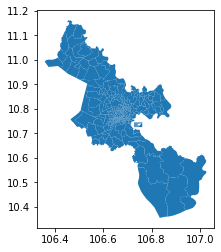

In [ ]:
# lu=lu.set_index('OBJECTID')
combined_zones=external_zones.append(lu).fillna(0)
combined_zones.plot()

### Create zone to zone distance matrix

In [ ]:
combined_zones['node']=net.get_node_ids(
                x_col=combined_zones['x_centroid'],y_col=combined_zones['y_centroid'])
print("combined_zones ", combined_zones)

combined_zones                 Com_Name   Dist_Name  ... emp_naics_nu        node
26734          Tan Dinh  District 1  ...          0.0  7933049451
26740          Ben Nghe  District 1  ...          0.0  7372999588
26752      Cau Ong Lanh  District 1  ...          0.0  7372999588
26746  Nguyen Thai Binh  District 1  ...          0.0  7372999588
26755          Co Giang  District 1  ...          0.0  7372999588
...                 ...         ...  ...          ...         ...
377                   0           0  ...          0.0  2153158641
378                   0           0  ...          0.0  2335061606
379                   0           0  ...          0.0  5780899266
380                   0           0  ...          0.0  8360798200
381                   0           0  ...          0.0  8393719038

[699 rows x 48 columns]


Takes a few minutes:

In [ ]:
zone_index=combined_zones.index
all_o_geoid=[]
for ind in zone_index:
    all_o_geoid.extend([ind]*len(zone_index))
all_d_geoid=list(zone_index)*len(zone_index)

all_o_nodes=combined_zones.loc[all_o_geoid,'node']
all_d_nodes=combined_zones.loc[all_d_geoid,'node']

all_dists=net.shortest_path_lengths(all_o_nodes,all_d_nodes, imp_name='distance')

In [ ]:
import pandas as pd
all_dists_mat=np.reshape(all_dists, (len(zone_index), len(zone_index)))
dist_mat_df=pd.DataFrame(all_dists_mat)
dist_mat_df.columns=combined_zones.index
dist_mat_df.index=combined_zones.index

dist_mat_df=dist_mat_df.replace(0, 50) #Replace zeros with a small distance to avid numerical issues

### Create population based on land uses

In [ ]:
import random
import numpy as np
import pandas as pd

def prob_floor(num):
    """
    Probabilistic "rounding" function
    eg. if num==1.2: this function will return 
    - 1.0 80% of the time 
    - 2.0 20% of the time
    """
    result=int(num)
    remainder=num-result
    if random.uniform(0, 1)<remainder:
        result+=1
    return result


def sample_home_locations(zones, work_geoid, dist_mat_df, n, beta=0.9):
    """ 
    Sample home locations using a simple gravity model.
    Attractiveness is proportional to the total residential capacity
    beta controls the distance decay
    """
    attraction=zones['res_total']
    impedance=[dist_mat_df.loc[hid,work_geoid] for hid in zones.index]
    # print(impedance)
    weights=np.divide(attraction,np.power(impedance, beta))
    # print("work_geoid", work_geoid)
    # print(max(weights/sum(weights)))
    return np.random.choice(
        zones.index, replace=True, p=weights/sum(weights), size=n)
    
def create_simpop(zones, sample_fraction=0.01):
    simpop=[]
    for geoid, row in zones.iterrows():
        for naics_col in industry_columns:
            naics_code=naics_col.split('emp_naics_')[1]
            capacity=row[naics_col]*sample_fraction
            n_workers=prob_floor(capacity)
            home_locations=sample_home_locations(zones, geoid, dist_mat_df, n_workers, beta=0.9)
            # TODO: age and income sampling should be weighted according to NAICS
            # i.e. people working in retail have a different age and income distribution to professionals
            earnings=np.random.choice(['1', '2', '3', '4'], replace=True,size=n_workers)
            age=np.random.choice(range(20,70), replace=True,size=n_workers)
            for i_w in range(n_workers):
                simpop.append({'work_geoid': geoid,'home_geoid': home_locations[i_w],
                                                   'naics': naics_code, 'earnings': earnings[i_w],
                                                  'age': age[i_w]})
    return simpop

In [ ]:
industry_columns=[col for col in lu.columns if 'emp_naics' in col]
res_income_columns=[col for col in lu.columns if 'res_income' in col]

In [ ]:
simpop=create_simpop(combined_zones, sample_fraction=0.001)
simpop_df=pd.DataFrame(simpop)

Only include people who either live OR work in the SIMULATION (table) area

In [ ]:
print(len(simpop_df))
simpop_df=simpop_df.loc[((simpop_df['home_geoid'].isin(lu.index))|(simpop_df['work_geoid'].isin(lu.index)))]
print(len(simpop_df))

# simpop_df=simpop_df.sample(50)

692
134


### Load the mode choice model

In [ ]:
import pickle
import json
mc_model=pickle.load(open('../outputs/mode_choice_model.p', 'rb'))
model_description=json.load(open('../outputs/mc_model_features.json'))

class Logistic_Mode_Choice_model():
    def __init__(self, mc_model, model_description):
        self.options=model_description['mode_order']
        self.features=model_description['features']
        self.dummy_map=model_description['dummy_map']
        self.model=mc_model
    
    def predict_modes(self, all_trips_df):
        data=all_trips_df.copy()
        for attr in self.dummy_map:
            dummys=pd.get_dummies(data[attr], prefix=self.dummy_map[attr])
            for col in dummys.columns:
                data[col]=dummys[col]
        for feat in self.features:
            if not feat in data.columns:
                print('{} not in data'.format(feat))
                data[feat]=0
        X=data[self.features]
        y_pred_proba=self.model.predict_proba(X)
        # Do all probabilistic samples with single call random number generator
        y_pred_proba_cum=np.cumsum(y_pred_proba, axis=1)
        p_cut=np.random.uniform(0, 1, len(data))
        y_pred=[self.options[np.argmax(y_pred_proba_cum[i]>p_cut[i])] for i in range(len(data))]
#         y_pred=[self.options[np.random.choice(range(len(y_pred_proba[i])), size=1, replace=True, p=y_pred_proba[i]
#                                 )[0]] for i in range(len(y_pred_proba))]
        all_trips_df['mode']=y_pred
        return all_trips_df

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


### Mode and profile descriptions

In [ ]:
mode_colors=['#7fc97f',
'#beaed4',
'#fdc086',
'#ffff99',
'#386cb0',
'#f0027f',
'#bf5b17']

mode_descriptions=[{'name': model_description['mode_order'][i], 'color': mode_colors[i]
                  } for i in range(len(model_description['mode_order']))]

profile_descriptions = [{"name": '1',
                        'color': "#7fc97f"},
                         {"name": '2',
                        'color': "#beaed4"},
                         {"name": '3',
                        'color': "#fdc086"},
                        {"name": '4',
                        'color': "#ffff99"},
                        ]

### Create Mobility System

All modes use same network but with different average speeds

In [ ]:
edges_df['travel_time_drive']=edges_df['distance']/(50000/3600) # 50km/hr
edges_df['travel_time_walk']=edges_df['distance']/(5000/3600) # 5km/hr
edges_df['travel_time_cycle']=edges_df['distance']/(12000/3600) # 12km/hr

net=pandana.Network(nodes_df["lon"], nodes_df["lat"], edges_df["from"], edges_df["to"],
                 edges_df[["distance", "travel_time_drive", "travel_time_walk", "travel_time_cycle"]])

In [ ]:
networks={}
networks['drive']=Simulation.PdnaNetwork(net)

building link attribute lookup


In [ ]:
mode_dicts={}
mode_dicts['Motorcycle']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}
mode_dicts['Bicycle']={'target_network_id': 'drive','travel_time_metric': 'travel_time_cycle'}
mode_dicts['Electric bicycle']={'target_network_id': 'drive','travel_time_metric': 'travel_time_cycle'}
mode_dicts['Walking']={'target_network_id': 'drive','travel_time_metric': 'travel_time_walk'}
mode_dicts['Bus']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}
mode_dicts['Car']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}
mode_dicts['Others']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}

In [ ]:
modes={mode: Simulation.Mode(mode_dicts[mode]) for mode in mode_dicts}
mob_sys=Simulation.MobilitySystem(modes=modes, networks=networks)

In [ ]:
sim=Simulation.Simulation(simpop_df, mob_sys, combined_zones, sim_geoids=lu.index,
            mode_descriptions=mode_descriptions, profile_descriptions=profile_descriptions)
sim.set_choice_models(mode_chooser=Logistic_Mode_Choice_model(mc_model, model_description))

Getting internal nodes
Finding closest nodes to every zone centroid


### Run the Simulation

In [ ]:
simpop_df=sim.create_simple_HWOWH_schedules(simpop_df)
all_trips_df=sim.create_trip_table(simpop_df)
all_trips_df['distance']=sim.mob_sys.networks['drive'].net.shortest_path_lengths(
    [n[0] for n in all_trips_df['from_possible_nodes_drive']],
    [n[0] for n in all_trips_df['to_possible_nodes_drive']],
    imp_name='distance')
all_trips_df=sim.mode_chooser.predict_modes(all_trips_df)
route_table=sim.get_routes_table(all_trips_df)
deckgl_trips=sim.routes_to_deckgl_trip(route_table)

emp_naics_11 not in data
emp_naics_21 not in data
emp_naics_23 not in data
emp_naics_48-49 not in data
emp_naics_52 not in data
emp_naics_62 not in data
emp_naics_81 not in data


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
../modules/CS_Spatial_Modules/Simulation.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_table_this_mode['node_path']=routes['node_path']
../modules/CS_Spatial_Modules/Simulation.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_table_this_mode['attributes']=routes

#### Create additional outputs

In [ ]:
route_gdf=sim.route_table_to_geo(route_table)
start_day_time_stamp=1626307200
trips_geo=sim.route_gdf_to_trips_geojson(route_gdf[['naics','earnings','age', 'mode', 'line_string', 'start_time', 'attributes', 'node_path']], 
                                         start_day_time_stamp=start_day_time_stamp)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


### Calculate a Mobility CO2 Indicator

Distances by mode (filtering out very large distances due to pandana failure to find route)

In [ ]:
distances_by_mode=route_table.loc[route_table['distance']<1e6].groupby('mode')['distance'].sum()
distances_by_mode

mode
Bicycle               28369.138
Bus                   34715.072
Car                    1143.603
Electric bicycle       2981.312
Motorcycle          1296588.599
Others                62170.510
Walking               55205.224
Name: distance, dtype: float64

Values below are guesses- need to be replaced by estimates specific to Vietnam/HCMC

In [ ]:
# #MIT's
# co2_kg_per_meter={'Motorcycle': 0.26/1000,
#                  'Car': 0.27/1000,
#                  'Electric bicycle': 0.1/1000,
#                  'Bicycle': 0,
#                  'Walking': 0,
#                  'Bus': 0.2/1000,
#                  'Others': 0.27/1000}

# Ours
co2_kg_per_meter={'Motorcycle': 0.02968/1000,
                 'Car': 0.2367/1000,
                 'Electric bicycle': 0.01/1000,
                 'Bicycle': 0,
                 'Walking': 0,
                 'Bus': 0.7632/1000,
                 'Others': 0.27/1000}

In [ ]:
total_co2=sum([distances_by_mode[mode]*co2_kg_per_meter[mode] for mode in distances_by_mode.index])
total_co2

82.06383421882

In [ ]:
co2_kg_per_person_day=total_co2/len(simpop_df)
co2_kg_per_person_day # rate = 0.001, our definition

0.6124166732747761

## Mobility Normalization

In [ ]:
#@title Norm mobility
min_mobility = 0
max_mobility = 2.72
mobility = {
    7: {0: co2_kg_per_person_day} 
} # fraction rate = 0.001 and our co2 definition

norm_mobility = {}
for dist_idx in [7]:
  norm_mobility[dist_idx] = {}
  for sim_idx in [0]:
    norm_mobility[dist_idx][sim_idx] = normalise_indicator(mobility[dist_idx][sim_idx], max_mobility, min_mobility)
print('norm mobility: ')
norm_mobility

norm mobility: 


{7: {0: 0.7748468112960383}}

#Compute accessibility for POIs in grid level

In [ ]:
#@title Amenity Heatmap Definition
def compute_closest_distance(centroids, pois):
  distances = []
  for j in centroids:
    distances.append(np.min([j.distance(x) for x in pois['geometry']]))
  return distances

def compute_accessibility_count(centroids, pois, max_dist=500):
  accessibility = []
  circles = centroids.buffer(max_dist)
  for j in circles:
    accessibility.append(np.sum([j.contains(x) for x in pois['geometry']]))
  return accessibility

In [ ]:
#@title Get grids from CityIO
from brix import Indicator, Handler
from brix.examples import Diversity, RandomIndicator
import random

# grids = {}
# for idx in [0, 2, 3]:
#   H = Handler('hcm_scenario_{}'.format(idx), quietly=False)
#   geo_data = H.get_geogrid_data(include_geometries=True)
#   grids[idx] = geo_data.as_df().to_crs('EPSG:32648')

#@markdown Get grids from files instead
grids = {}
for idx in [0, 2, 3]:
  #H = Handler('hcm_scenario_{}'.format(idx), quietly=False)
  #geo_data = H.get_geogrid_data(include_geometries=True)
  geo_data = gpd.read_file('/content/drive/MyDrive/Cityscope_CSL/geogrid_scenario_3.geojson')
  grids[idx] = geo_data.to_crs('EPSG:32648')

In [ ]:
#@title Amenity Heatmap Computation
Accessibilities = {}
num_pois = {}
for sim_idx in [0]:
  Accessibilities[sim_idx] = {}
  num_pois[sim_idx] = {}
  for amenity in amenities:
    # print(amenity)
    start_time = time.time()
    pois = all_pois[sim_idx][amenity]
    num_pois[sim_idx][amenity] = len(pois)
    Accessibilities[sim_idx][amenity] = compute_accessibility_count(full_attr_buildings[0].centroid, pois)
    print(amenity, "--- %s seconds ---" % (time.time() - start_time))
print('num_pois', num_pois)

import numpy as np
avg_accessibility = {}

for sim_idx in [0]:
  avg_accessibility[sim_idx] = {}
  for amenity in amenities:
      avg_accessibility[sim_idx][amenity] = np.average(Accessibilities[sim_idx][amenity])
    
print("avg_accessibility ", avg_accessibility)

medical --- 1.0430207252502441 seconds ---
park --- 12.289442777633667 seconds ---
education --- 3.5247950553894043 seconds ---
commercial --- 59.522212982177734 seconds ---
num_pois {0: {'medical': 3, 'park': 246, 'education': 55, 'commercial': 1206}}
avg_accessibility  {0: {'medical': 0.2678189939794135, 'park': 46.50844824237716, 'education': 10.54107593707516, 'commercial': 262.41114779568846}}


scenario:  0
medical --- 0.8632791042327881 seconds ---


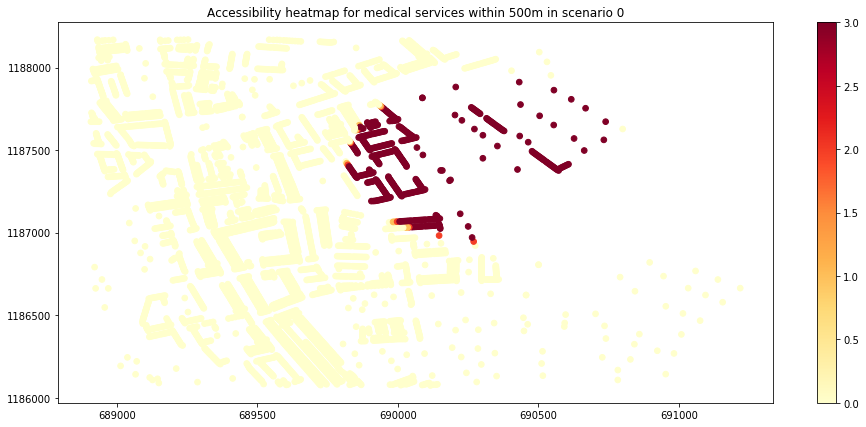

park --- 0.8530583381652832 seconds ---


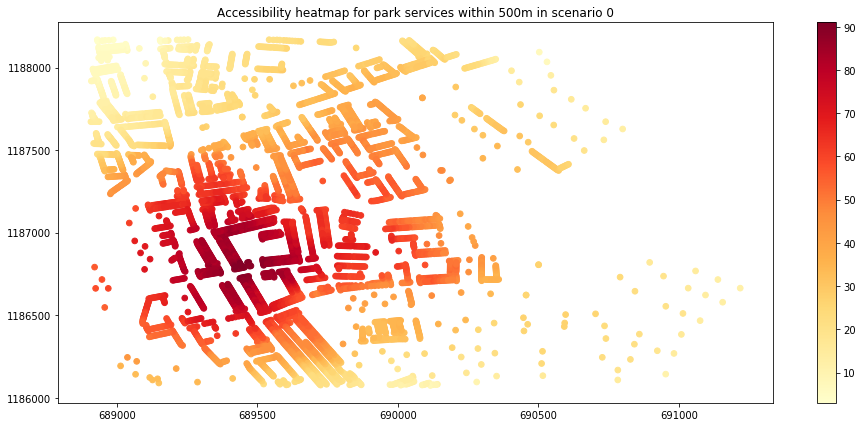

education --- 0.9037773609161377 seconds ---


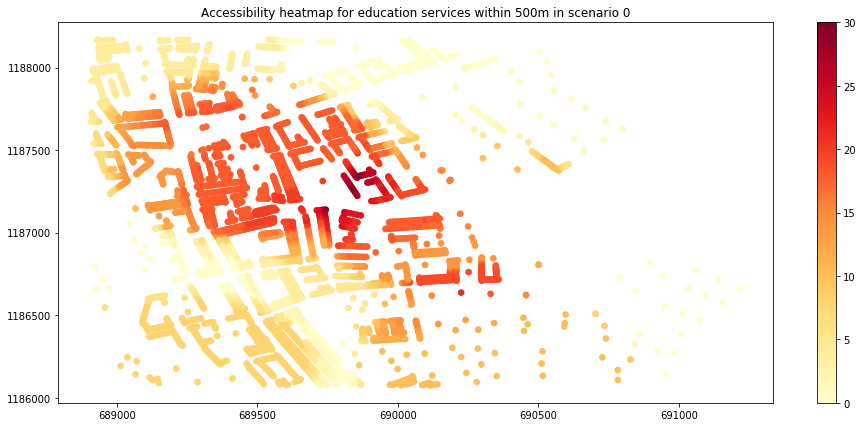

commercial --- 0.8741378784179688 seconds ---


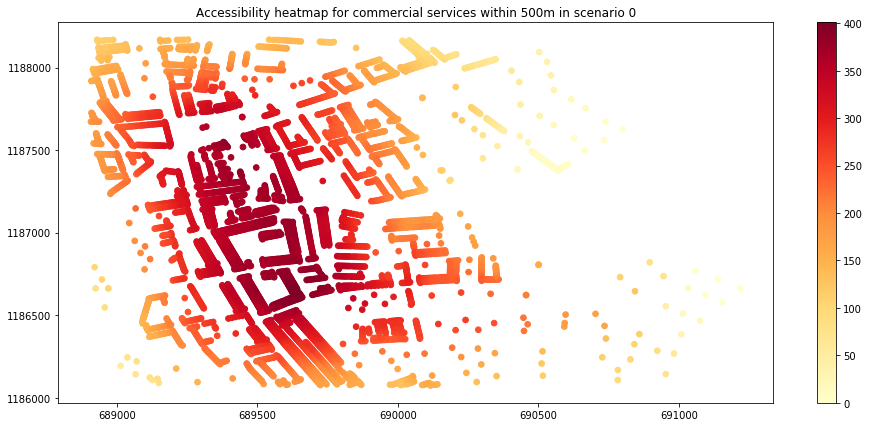

In [ ]:
#@title Amenity Heatmap Visualization
for sim_idx in [0]:
    print("scenario: ", sim_idx)
    for amenity in amenities:
        start_time = time.time()
        fig, ax = plt.subplots(figsize=(16,7))
        plt.title('Accessibility heatmap for {} services within 500m in scenario {}'.format(amenity, sim_idx))
        plt.scatter(full_attr_buildings[0].centroid.geometry.x, full_attr_buildings[0].centroid.geometry.y, 
                    c=Accessibilities[sim_idx][amenity], s=32, cmap='YlOrRd')
        cb = plt.colorbar()
        print(amenity, "--- %s seconds ---" % (time.time() - start_time))
        plt.savefig('/content/drive/MyDrive/Cityscope_L3_SGP/Heatmap/SGP-non-interact/sgp_non_interact' + str(amenity) + '_{}'.format(sim_idx) + '.png', transparent=True)
        plt.show()

#Compute accessibility for Resident and Employee in grid level

In [ ]:
#@title Get grids from CityIO
from brix import Indicator, Handler
from brix.examples import Diversity, RandomIndicator
import random

# grids = {}
# for idx in [0, 2, 3]:
#   H = Handler('hcm_scenario_{}'.format(idx), quietly=False)
#   geo_data = H.get_geogrid_data(include_geometries=True)
#   grids[idx] = geo_data.as_df().to_crs('EPSG:32648')

#@markdown Get grids from files instead
grids = {}
for idx in [0]:
  #H = Handler('hcm_scenario_{}'.format(idx), quietly=False)
  #geo_data = H.get_geogrid_data(include_geometries=True)
  geo_data = gpd.read_file('/content/drive/MyDrive/Cityscope_L3_SGP/sgp_test/geogrid_scenario_2.geojson')
  grids[idx] = geo_data.to_crs('EPSG:32648')

In [ ]:
#@title Res/Emp Computing Function Definition
from tqdm import tqdm

def compute_accessibility_accumulate(centroids, pois, field_name='res_total', max_dist=500):
  accessibility = []
  for centroid in tqdm(centroids):
    circle = centroid.buffer(max_dist)
    circle_df = gpd.GeoDataFrame({'geometry': [circle]}, crs=pois.crs)
    pois_within = gpd.sjoin(pois, circle_df, op='within')
    accessibility.append(np.sum(pois_within[field_name]))
  return accessibility

In [ ]:
#@title Default title text
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# full_attr_buildings[0].centroid

In [ ]:
#@title Res/Emp Heatmap Computation
Accessibilities = {}
num_pois = {}
for sim_idx in [0]:
  Accessibilities[sim_idx] = {}
  num_pois[sim_idx] = {}

  for field_name in ['res_total', 'emp_total']:
    print("scenario {}, field {}".format(sim_idx, field_name))
    pois = full_attr_buildings[sim_idx][full_attr_buildings[sim_idx][field_name]!=0.0]
    num_pois[sim_idx][field_name] = len(pois)
    Accessibilities[sim_idx][field_name] = compute_accessibility_accumulate(full_attr_buildings[0].centroid, pois, field_name)

avg_accessibility = {}
for sim_idx in [0]:
  avg_accessibility[sim_idx] = {}
  for field_name in ['res_total', 'emp_total']:
      avg_accessibility[sim_idx][field_name] = np.average(Accessibilities[sim_idx][field_name])
print("avg_accessibility ", avg_accessibility)

scenario 0, field res_total


100%|██████████| 5149/5149 [02:43<00:00, 31.56it/s]


scenario 0, field emp_total


100%|██████████| 5149/5149 [01:24<00:00, 61.28it/s]

avg_accessibility  {0: {'res_total': 42646.42647988332, 'emp_total': 4841.88870912226}}


scenario:  0


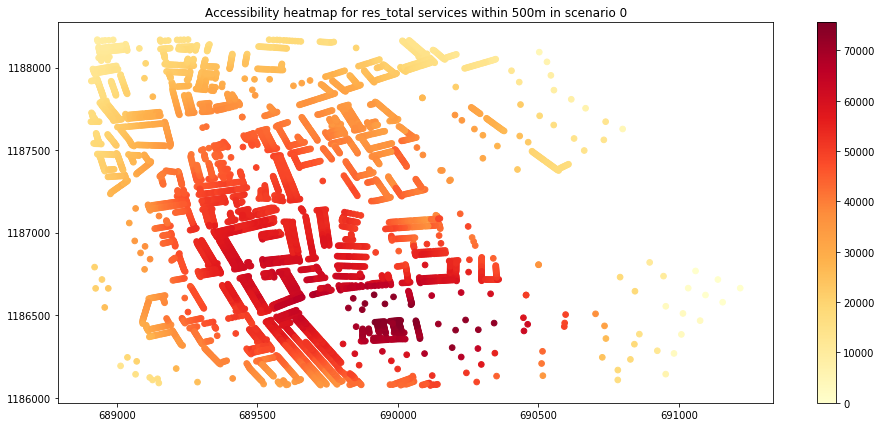

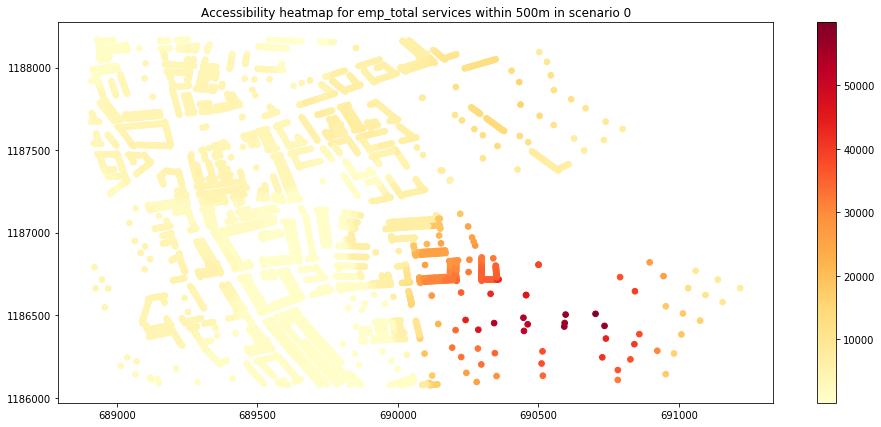

In [ ]:
#@title Res/Emp Heatmap Visualization
for sim_idx in [0]:
    print("scenario: ", sim_idx)
    for amenity in ['res_total', 'emp_total']:
        fig, ax = plt.subplots(figsize=(16,7))
        plt.title('Accessibility heatmap for {} services within 500m in scenario {}'.format(amenity, sim_idx))
        plt.scatter(full_attr_buildings[0].centroid.geometry.x, full_attr_buildings[0].centroid.geometry.y, 
                    c=Accessibilities[sim_idx][amenity], s=32, cmap='YlOrRd')
        cb = plt.colorbar()
        # plt.savefig('/content/drive/MyDrive/Cityscope_CSL/Heatmap_Oct20/' + str(amenity) + '_{}'.format(sim_idx) + '.png')
        plt.show()

In [ ]:
#@title other
import numpy as np

# Save
np.save('/content/Accessibilities.npy', Accessibilities) 

# Load
# Accessibilities = np.load('/content/drive/MyDrive/Cityscope_CSL/Accessibilities.npy', allow_pickle='TRUE').item()
# Accessibilities[0].keys()